In [1]:
import numpy as np
import torch
from ADEN import ADEN
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
def d_t(x, y):
    return 0.5 * torch.sum((x - y)** 2) 

In [3]:
# creating an example dataset
# x = torch.tensor([[1.0, 2.0], [3.0, 4.0]]).unsqueeze(0)
# y = torch.tensor([[0.0, 0.0], [1.0, -1.0], [5.0, 1.0]]).unsqueeze(0)
# dists = torch.cdist(x,y, p=2)**2
# model = ADEN(input_dim=2, d_model=64, n_layers=3, d_ff=128).to('cpu')
# model(x,y)

In [4]:
N = 100 # number of samples
M = 30 # number of clusters
Batch_size = 16 # number of batches
num_samples_in_batch = 8 # number of samples in each batch
input_dim = 2 # dimensionality of the input space
# X = torch.rand(N, input_dim).to(device)  # example input tensor (N, input_dim)
X = torch.tensor(np.loadtxt("D31.txt")[:,:2],device=device,dtype=torch.float32) / 31
N = X.shape[0]
Y = torch.rand(M, input_dim).to(device)  # example cluster tensor (M, input_dim)
model = ADEN(input_dim=input_dim, d_model=64, n_layers=3, d_ff=128).to(device)
import torchsummary
torchsummary.summary(model, [(N, input_dim), (M, input_dim)])
# visualize the model architecture


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1             [-1, 3100, 64]             192
            Linear-2               [-1, 30, 64]             192
            Linear-3             [-1, 3100, 64]           4,096
            Linear-4               [-1, 30, 64]           4,096
            Linear-5               [-1, 30, 64]           4,096
           Dropout-6          [-1, 8, 3100, 30]               0
            Linear-7             [-1, 3100, 64]           4,160
MultiHeadDistanceAttention-8             [-1, 3100, 64]               0
           Dropout-9             [-1, 3100, 64]               0
        LayerNorm-10             [-1, 3100, 64]             128
           Linear-11            [-1, 3100, 128]           8,320
             GELU-12            [-1, 3100, 128]               0
          Dropout-13            [-1, 3100, 128]               0
           Linear-14           

In [5]:
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-5)
Y_batches = (
    Y.unsqueeze(0).expand(Batch_size, -1, -1).to(device)
)  # (Batch_size, M, input_dim)
for epoch in range(500):  # example training loop

    X_batches = torch.zeros(Batch_size, num_samples_in_batch, input_dim).to(
        device
    )  # (Batch_size, num_samples_in_batch, input_dim)
    for i in range(Batch_size):
        batch_indices = torch.randint(0, N, (num_samples_in_batch,)).to(device)
        X_batches[i] = X[batch_indices]

    predicted_distances = model(
        X_batches, Y_batches
    )  # predicted distances (Batch_size, num_samples_in_batch, M)
    idx = torch.argmin(
        predicted_distances, dim=-1
    ).long()  # indices of the closest clusters (Batch_size, num_samples_in_batch)
    # create a mask of chosen indices to only include them in the training error
    mask = torch.zeros_like(predicted_distances, dtype=torch.bool)
    mask.scatter_(2, idx.unsqueeze(2), 1)  # (Batch_size, num_samples_in_batch, M)
    gamma = 100.0
    transition_probs = torch.exp(-gamma * torch.cdist(Y, Y, p=2) ** 2)  # (M, M)
    transition_probs = transition_probs / transition_probs.sum(dim=-1, keepdim=True)
    D = torch.zeros(Batch_size, num_samples_in_batch, M).to(
        device
    )  # (Batch_size, num_samples_in_batch)
    for b in range(Batch_size):
        for i in range(num_samples_in_batch):
            realized_cluster = torch.multinomial(transition_probs[idx[b][i]], 1).item()
            D[b][i][idx[b][i]] = d_t(X_batches[b][i], Y_batches[b][realized_cluster])
    # take MSE error between D and predicted_distances only when mask is true
    mse_loss = torch.sum((D[mask] - predicted_distances[mask]) ** 2)
    if epoch % 10 == 0:
        print(f"Epoch {epoch}, MSE Loss: {mse_loss.item()}")
    optimizer.zero_grad()
    mse_loss.backward()
    optimizer.step()

Epoch 0, MSE Loss: 0.012990714982151985
Epoch 10, MSE Loss: 0.010740525089204311
Epoch 20, MSE Loss: 0.0044959532096982
Epoch 30, MSE Loss: 0.006224015261977911
Epoch 40, MSE Loss: 0.009251445531845093
Epoch 50, MSE Loss: 0.006109796464443207
Epoch 60, MSE Loss: 0.0045158714056015015
Epoch 70, MSE Loss: 0.006029574666172266
Epoch 80, MSE Loss: 0.005682009272277355
Epoch 90, MSE Loss: 0.009485265240073204
Epoch 100, MSE Loss: 0.0037235659547150135
Epoch 110, MSE Loss: 0.004968636203557253
Epoch 120, MSE Loss: 0.0069285230711102486
Epoch 130, MSE Loss: 0.0043910169042646885
Epoch 140, MSE Loss: 0.009391851723194122
Epoch 150, MSE Loss: 0.005467178300023079
Epoch 160, MSE Loss: 0.006585391238331795
Epoch 170, MSE Loss: 0.007319921627640724
Epoch 180, MSE Loss: 0.007324662990868092
Epoch 190, MSE Loss: 0.008140729740262032
Epoch 200, MSE Loss: 0.006778675597161055
Epoch 210, MSE Loss: 0.00622203154489398
Epoch 220, MSE Loss: 0.00427806144580245
Epoch 230, MSE Loss: 0.004163694567978382
Epo

In [6]:
y_to_be_optimized = Y.clone().detach().requires_grad_(True)  # make Y a parameter to be optimized
# fix model weights
for param in model.parameters():
    param.requires_grad = False
model.eval()

ADEN(
  (data_projection): Linear(in_features=2, out_features=64, bias=True)
  (cluster_projection): Linear(in_features=2, out_features=64, bias=True)
  (blocks): ModuleList(
    (0-2): 3 x AdaptiveDistanceBlock(
      (attention): MultiHeadDistanceAttention(
        (W_q): Linear(in_features=64, out_features=64, bias=False)
        (W_k): Linear(in_features=64, out_features=64, bias=False)
        (W_v): Linear(in_features=64, out_features=64, bias=False)
        (W_o): Linear(in_features=64, out_features=64, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (norm1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      (norm2): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      (ffn): Sequential(
        (0): Linear(in_features=64, out_features=128, bias=True)
        (1): GELU(approximate='none')
        (2): Dropout(p=0.1, inplace=False)
        (3): Linear(in_features=128, out_features=64, bias=True)
        (4): Dropout(p=0.1, inplace=False)
 

In [17]:
optimizer_y = torch.optim.AdamW([y_to_be_optimized], lr=1e-3, weight_decay=1e-5)

beta = 500
F_old = torch.tensor(float('inf'), device=device)  # Initialize F_old to a large value
epoch = 0
while True:
    # Update y_to_be_optimized using the gradients
    d_s = model(X.unsqueeze(0), y_to_be_optimized.unsqueeze(0))[0] # (N, M)
    F = -1/beta*torch.sum(torch.log(torch.sum(torch.exp(-beta*d_s), dim=-1)))
    optimizer_y.zero_grad()
    F.backward()
    optimizer_y.step()
    if epoch % 100 == 0:
        print(f"Epoch {epoch}, F: {F.item()}")
    if torch.norm(F_old - F)/torch.norm(F_old) < 1e-6:
        break
    F_old = F.clone()  # Update F_old for the next iteration
    epoch += 1

Epoch 0, F: 11.593018531799316


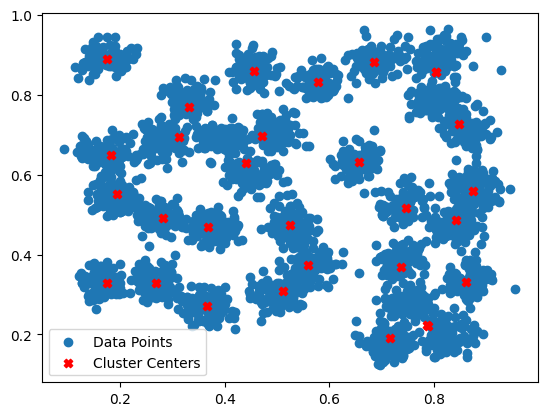

In [18]:
# plot locations of X and final y
import matplotlib.pyplot as plt
# converting results to numpy
X_np = X.detach().cpu().numpy()
y_np = y_to_be_optimized.detach().cpu().numpy()
plt.scatter(X_np[:, 0], X_np[:, 1], label='Data Points')
plt.scatter(y_np[:, 0], y_np[:, 1], label='Cluster Centers', marker='X', color='red')
plt.legend()
plt.show()

In [19]:
model(X.unsqueeze(0), y_to_be_optimized.unsqueeze(0))[0]

tensor([[0.1685, 0.2554, 0.0598,  ..., 0.0227, 0.1589, 0.1042],
        [0.1675, 0.2577, 0.0487,  ..., 0.0197, 0.1821, 0.1254],
        [0.1641, 0.2508, 0.0550,  ..., 0.0204, 0.1604, 0.1060],
        ...,
        [0.0427, 0.0228, 0.1697,  ..., 0.1810, 0.0340, 0.0635],
        [0.0362, 0.0233, 0.1479,  ..., 0.1547, 0.0239, 0.0477],
        [0.0264, 0.0123, 0.1383,  ..., 0.1546, 0.0371, 0.0625]],
       device='cuda:0', grad_fn=<SelectBackward0>)

In [20]:
0.5*torch.cdist(X, y_to_be_optimized, p=2)**2

tensor([[0.1652, 0.2520, 0.0564,  ..., 0.0194, 0.1555, 0.1009],
        [0.1641, 0.2543, 0.0454,  ..., 0.0164, 0.1787, 0.1220],
        [0.1607, 0.2474, 0.0517,  ..., 0.0171, 0.1571, 0.1027],
        ...,
        [0.0394, 0.0195, 0.1664,  ..., 0.1777, 0.0306, 0.0602],
        [0.0328, 0.0200, 0.1446,  ..., 0.1513, 0.0205, 0.0444],
        [0.0230, 0.0090, 0.1349,  ..., 0.1512, 0.0337, 0.0591]],
       device='cuda:0', grad_fn=<MulBackward0>)